In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys

sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang")

In [3]:
import ebb

ebb.__file__

'/Users/flynnwang/repo/flynn/eco_bang_bang/ebb/__init__.py'

In [4]:
import torch

from ebb.env.luxenv import get_ob_sapce
from ebb.model import _create_model, RewardSpec

reward_spec = RewardSpec(
        reward_min=-5,
        reward_max=+5,
        zero_sum=False,
    )

reward_shaping_params = dict(
  new_observed_down_tri=0.0001,
  match_observed=0,
  match_win=1,
  use_hidden_relic_estimator=True,
  energy_cost_change=0.001,                             
)

obs_space_kwargs = {
    'use_energy_cost_map': True,
    'use_single_player': False,
    "use_agent": False,
}

# Load model

In [5]:
# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_2025026_imitation_r0/011321856_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250207_behaviour_cloning_test_run_v4/000161856_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250208_behaviour_cloning_r0_with_drift_estimation_cont3/027721664_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250210_post_training_full_kl_and_entropy_r0/028716800_weights.pt"

model_path = "/Users/flynnwang/repo/flynn/runs/mds/submits/run_20250211_post_training_game_win_loss_cont_r2/069065216_weights.pt"

ob_space = get_ob_sapce(obs_space_kwargs)
model = _create_model(ob_space, reward_spec=reward_spec, n_blocks=8, hidden_dim=128, base_out_channels=128,
                      embedding_dim=16, kernel_size=5, use_separate_base=False)


checkpoint_state = torch.load(model_path, map_location=torch.device("cpu"), weights_only=True)
model.load_state_dict(checkpoint_state["model_state_dict"])

<All keys matched successfully>

# Model Run

In [6]:
from luxai_s3.params import EnvParams

from luxai_s3.wrappers import LuxAIS3GymEnv, RecordEpisode
from ebb.env.luxenv import LuxS3Env
from ebb.env.wrappers import VecEnv, PytorchEnv, DictEnv
from ebb.torchbeast.core.selfplay import split_env_output_by_player, pair_env_output_for_players


def actor_model_apply(env_output, sample=True):
  lef_env_out, rig_env_out = split_env_output_by_player(env_output)
  lef_agent_out = actor_model(lef_env_out, sample=sample, probs_output=True)
  rig_agent_out = actor_model(rig_env_out, sample=sample, probs_output=True)
  return [(lef_env_out, lef_agent_out), (rig_env_out, rig_agent_out)]

def get_merged_actions(env_agent_out):
  lef_actions = env_agent_out[0][1]['actions']
  rig_actions = env_agent_out[1][1]['actions']
  return pair_env_output_for_players(lef_actions, rig_actions)

class AgentStats:

    def __init__(self):
        self.baseline = []


    def add_baseline(self, b):
        self.baseline.append(float(b.detach().numpy()))

        

In [7]:
game_env = LuxAIS3GymEnv(numpy_output=True)
game_env = RecordEpisode(game_env, save_dir="episodes1")

lux_env = LuxS3Env('match_explore_win_loss', 
                   obs_space_kwargs,
                   game_env,
                   reward_shaping_params=reward_shaping_params)
env = VecEnv([lux_env])
env = PytorchEnv(env, torch.device('cpu'))
env = DictEnv(env)

actor_model = model

env_output = env.reset(force=True, seed=96290790)
# env_output = env.reset(force=True)

a1_stats = AgentStats()
a2_stats = AgentStats()


use_single_player = obs_space_kwargs['use_single_player']
cnt = 0
while True:
    env_agent_output = actor_model_apply(env_output)
    print('action mask', env_agent_output[0][0]['info']['available_action_mask']['units_action'][0][0])
    print('probs ~~~~~~~~~~~', env_agent_output[0][1]['probs'])
    print('actions ~~~~~~~~~~~', env_agent_output[0][1]['actions'])

    
    a1_stats.add_baseline(env_agent_output[0][1]['baseline'][0][0])
    a2_stats.add_baseline(env_agent_output[1][1]['baseline'][0][0])

    actions = get_merged_actions(env_agent_output)
    env_output = env.step(actions)

    cnt += 1
    if cnt >= 300:
        break # for debut
    if env_output["done"].any():
        break

game_env.close()

lux_env._seed

set env_state to None..............
set env_state to None..............
action mask tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

***** --> found energy node at [ 2 13]
step=0 (after update), energy field found=True, node=[ 2 13], candidates=[array([ 2, 13])]
--> using energy node at [ 2 13]
***** --> found energy node at [ 2 13]


set env_state to None..............


step=0 (after update), energy field found=True, node=[ 2 13], candidates=[array([ 2, 13])]
--> using energy node at [ 2 13]


action mask tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

***** --> found energy node at [ 4 13]
----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
***** --> found energy node at [ 4 13]


set env_state to None..............


----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=2 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=2 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=3 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=3 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=4 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=4 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=5 (after update), energy field foun

action mask tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=8, apply nebula drift = -0.15, Counter({-0.15: 2, 0.15: 0, -0.1: -99, -0.05: -99, -0.025: -99, 0.025: -99, 0.05: -99, 0.1: -99})
step=7 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=8, apply nebula drift = -0.15, Counter({-0.15: 2, 0.15: 0, -0.1: -99, -0.05: -99, -0.025: -99, 0.025: -99, 0.05: -99, 0.1: -99})
step=7 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=8 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=8 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=9 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=9 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node

action mask tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=15, apply nebula drift = -0.15, Counter({-0.15: 3, 0.15: -1, -0.1: -199, -0.05: -199, -0.025: -199, 0.025: -199, 0.05: -199, 0.1: -199})
step=14 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=15, apply nebula drift = -0.15, Counter({-0.15: 3, 0.15: -1, -0.1: -199, -0.05: -199, -0.025: -199, 0.025: -199, 0.05: -199, 0.1: -199})
step=14 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=15 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=15 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=16 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=16 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=22 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=22 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=23 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=23 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=24 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=24 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=25 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=25 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]


action mask tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=29 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=29 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=30 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=30 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=31 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=31 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=32 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=32 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]


action mask tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=35 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=35 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=36 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=36 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=37 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=37 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=38 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=38 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]


action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=41 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=41 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=42 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=42 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=43 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=43 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=44 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=44 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]


action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=48 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=48 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=49 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=49 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=50 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=50 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=51 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=51 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]


action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=55 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=55 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=56 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=56 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=57 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=57 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=58 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=58 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]


action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=59 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=59 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=61, apply nebula drift = -0.15, Counter({-0.15: 10, 0.15: -8, -0.1: -596, -0.05: -596, 0.05: -602, 0.1: -602, -0.025: -798, 0.025: -800})
step=60 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=61, apply nebula drift = -0.15, Counter({-0.15: 10, 0.15: -8, -0.1: -596, -0.05: -596, 0.05: -602, 0.1: -602, -0.025: -798, 0.025: -800})
step=60 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=61 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=61 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13]

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=66 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=66 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=68, apply nebula drift = -0.15, Counter({-0.15: 11, 0.15: -9, -0.1: -696, -0.05: -696, 0.05: -702, 0.1: -702, -0.025: -898, 0.025: -900})
step=67 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=68, apply nebula drift = -0.15, Counter({-0.15: 11, 0.15: -9, -0.1: -696, -0.05: -696, 0.05: -702, 0.1: -702, -0.025: -898, 0.025: -900})
step=67 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=68 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=68 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13]

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=73 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=73 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=75, apply nebula drift = -0.15, Counter({-0.15: 12, 0.15: -10, -0.1: -796, -0.05: -796, 0.05: -802, 0.1: -802, -0.025: -998, 0.025: -1000})
step=74 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=75, apply nebula drift = -0.15, Counter({-0.15: 12, 0.15: -10, -0.1: -796, -0.05: -796, 0.05: -802, 0.1: -802, -0.025: -998, 0.025: -1000})
step=74 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=75 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=75 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4,

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=81, apply nebula drift = -0.15, Counter({-0.15: 13, 0.15: -11, -0.1: -795, -0.05: -795, 0.05: -803, 0.1: -803, -0.025: -997, 0.025: -1001})
step=80 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=81, apply nebula drift = -0.15, Counter({-0.15: 13, 0.15: -11, -0.1: -795, -0.05: -795, 0.05: -803, 0.1: -803, -0.025: -997, 0.025: -1001})
step=80 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=81 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=81 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=82 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=82 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4,

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=88, apply nebula drift = -0.15, Counter({-0.15: 14, 0.15: -12, -0.1: -895, -0.05: -895, 0.05: -903, 0.1: -903, -0.025: -1097, 0.025: -1101})
step=87 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=88, apply nebula drift = -0.15, Counter({-0.15: 14, 0.15: -12, -0.1: -895, -0.05: -895, 0.05: -903, 0.1: -903, -0.025: -1097, 0.025: -1101})
step=87 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=88 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=88 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=89 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=89 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=95, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=94 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=95, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=94 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=95 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=95 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=96 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=96 (after update), energy field found=True, node=[ 4 13], candidates=[arra

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

***** --> found energy node at [ 8 11]
----------small reset energy node positions, found? = True
energy field changed at step = 101
step=101 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]


set env_state to None..............


***** --> found energy node at [ 8 11]
----------small reset energy node positions, found? = True
energy field changed at step = 101
step=101 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=102 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=102 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=103 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=103 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=104 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=104 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy n

action mask tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=108 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=108 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=109 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=109 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=110 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=110 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=111 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=111 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at 

action mask tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=115 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=115 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=116 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=116 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=117 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=117 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=118 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=118 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=122 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=122 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=123 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=123 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=124 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=124 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=125 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=125 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at 

action mask tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=129 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=129 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=130 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=130 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=131 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=131 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=132 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=132 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=136 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=136 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=137 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=137 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=138 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=138 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=139 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=139 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=143 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=143 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=144 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=144 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=145 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=145 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=146 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=146 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=150 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=150 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=151 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=151 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=152 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=152 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=153 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=153 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=157 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=157 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=158 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=158 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=159 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=159 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=161, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=160 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=164 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=164 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=165 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=165 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=166 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=166 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=168, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=167 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=170 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=170 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=171 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=171 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=172 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=172 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=173 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=173 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=177 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=177 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=178 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=178 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=179 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=179 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=181, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=180 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=184 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=184 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=185 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=185 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=186 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=186 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=188, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=187 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=191 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=191 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=192 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=192 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=193 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=193 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=195, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=194 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--

action mask tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=198 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=198 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=199 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=199 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=201, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=200 (after update), energy field found=True, node=[ 8 11], candidates=[array([ 8, 11])]
--> using energy node at [ 8 11]
step=201, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=200 (after update), energy field found=True, node=[ 8 11], candidat

set env_state to None..............


***** --> found energy node at [ 9 14]
----------small reset energy node positions, found? = True
energy field changed at step = 201
step=201 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=202 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=202 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=203 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=203 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=204 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=204 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy n

action mask tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=206 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=206 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=208, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=207 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=208, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=207 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=208 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=208 (after update), energy field found=True, node=[ 9 14], candidat

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=211 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=211 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=212 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=212 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=213 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=213 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=215, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=214 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=218 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=218 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=219 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=219 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=221, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=220 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=221, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=220 (after update), energy field found=True, node=[ 9 14], candidat

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=225 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=225 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=226 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=226 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=228, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=227 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=228, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=227 (after update), energy field found=True, node=[ 9 14], candidat

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=229 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=229 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=230 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=230 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=231 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=231 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=232 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=232 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=236 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=236 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=237 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=237 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=238 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=238 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=239 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=239 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=243 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=243 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=244 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=244 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=245 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=245 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=246 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=246 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=250 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=250 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=251 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=251 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=252 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=252 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=253 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=253 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at 

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=257 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=257 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=258 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=258 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=259 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=259 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=261, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=260 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=264 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=264 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=265 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=265 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=266 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=266 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=268, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=267 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=271 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=271 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=272 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=272 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=273 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=273 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=275, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=274 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--

action mask tensor([1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=278 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=278 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=279 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=279 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=281, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=280 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=281, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=280 (after update), energy field found=True, node=[ 9 14], candidat

action mask tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=285 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=285 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=286 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=286 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=288, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=287 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=288, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=287 (after update), energy field found=True, node=[ 9 14], candidat

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=292 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=292 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=293 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=293 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=295, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=294 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=295, apply nebula drift = -0.15, Counter({-0.15: 15, 0.15: -13, -0.1: -995, -0.05: -995, 0.05: -1003, 0.1: -1003, -0.025: -1197, 0.025: -1201})
step=294 (after update), energy field found=True, node=[ 9 14], candidat

action mask tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 

step=299 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]
step=299 (after update), energy field found=True, node=[ 9 14], candidates=[array([ 9, 14])]
--> using energy node at [ 9 14]


96290790

In [8]:
env_agent_output[0][1].keys()

dict_keys(['actions', 'policy_logits', 'baseline', 'probs'])

In [9]:
env_agent_output[0][1]['probs']

tensor([[0.9567, 0.0258, 0.0026,  ..., 0.0000, 0.0000, 0.0000],
        [0.9632, 0.0000, 0.0093,  ..., 0.0000, 0.0000, 0.0000],
        [0.9056, 0.0389, 0.0181,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1126, 0.0000, 0.2729,  ..., 0.0000, 0.0000, 0.0000],
        [0.1062, 0.0247, 0.0241,  ..., 0.0000, 0.0000, 0.0000],
        [0.1037, 0.0248, 0.0242,  ..., 0.0000, 0.0000, 0.0000]])

In [10]:
1

1

<Axes: >

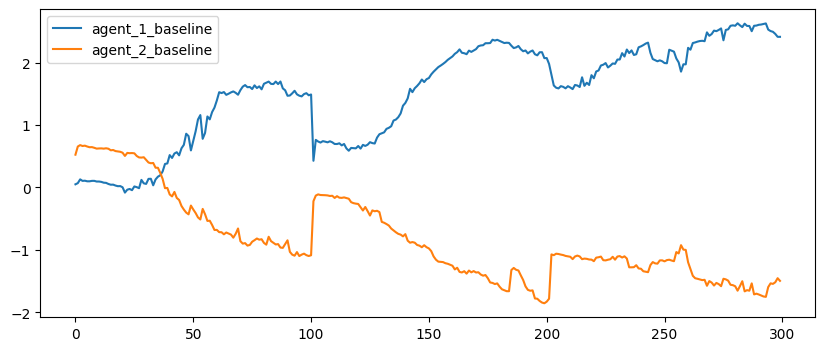

In [11]:
data = {
    'agent_1_baseline': a1_stats.baseline,
    'agent_2_baseline': a2_stats.baseline,   
}

pd.DataFrame(data)[['agent_1_baseline', 'agent_2_baseline']].plot(figsize=(10, 4))